# COMP5329 - Deep Learning
## Assignment 2 - Multilabel Classification

*   Nirav Desai
*   Rebecca Chan

## Initial Set up
### Load packages

In [ ]:
## Load Libraries
import re, os
import pandas as pd
from io import StringIO
from google.colab import drive

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import itertools
import os

from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from torch import optim
from sklearn.metrics import classification_report

torch.__version__

'1.8.1+cu101'

##### Mount google drive
##### Use GPU If available

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')



We are using GPU.


In [ ]:
drive.mount('/content/gdrives')

Mounted at /content/gdrives


### Select Drive Path for Teammates

**Values :** 
- rebecca : Rebecca's drive config
- nirav : Nirav's drive config

In [ ]:
## Input name to get correct drive path
name = input()
if name == 'rebecca':
  data_path = '/content/gdrives/MyDrive/COMP5329_attempt2'
elif name == 'nirav': 
  data_path = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset'

rebecca


## Load Dataset Function

**Inputs:**
  1. Root Directory for Images
  2. csv filename with annotations
  3. Pytorch transform object

**Outputs:**
  - Training and Validation Set
    - 2 different method per user (Rebecca and Nirav) due to drive paths
    - tuple with image as a tensor and corresponding target One-Hot encoded label as tensor (image, label)
  - Test Set
    - image as a tensor

In [ ]:
if name == 'rebecca':
  class load_data(Dataset):
      def __init__(self, root_dir, annotation_file, transform=None):
          with open(root_dir+'/'+annotation_file) as train: 
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
            train_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')

          self.root_dir = root_dir
          self.annotations = train_labels
          self.transform = transform

      def __len__(self):
          return len(self.annotations)

      def __getitem__(self, index):
          img_id = self.annotations.iloc[index, 0]
          val_temp = val_temp = int(re.search('^\d+\.', img_id).group(0)[:-1])
          if val_temp < 5000: 
            folder_dir = 'folder_1'
          elif val_temp < 10000: 
            folder_dir = 'folder_2'
          elif val_temp < 15000: 
            folder_dir = 'folder_3'
          elif val_temp < 20000: 
            folder_dir = 'folder_4'
          elif val_temp < 25000: 
            folder_dir = 'folder_5'
          elif val_temp < 30000:
            folder_dir = 'folder_6'
          img = Image.open(os.path.join(self.root_dir+'/uploads/'+folder_dir, img_id)).convert("RGB")
          split_label = self.annotations.iloc[index, 1].split()
          num_labels = list(map(int, split_label))
          label = torch.LongTensor(num_labels) - 1
          one_hot_labels = torch.zeros(size=([19]), dtype=torch.float64)
          # print(label, self.one_hot_labels.shape, label.shape)
          y_label = one_hot_labels.scatter_(dim=0, index=label, value=1.)
          # y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

          if self.transform is not None:
              img = self.transform(img)

          return (img, y_label)

  class load_test_data(Dataset):
      def __init__(self, root_dir, annotation_file, transform=None): 
          with open(root_dir + '/' + annotation_file) as test: 
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in test]
            test_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')    

          self.root_dir = root_dir
          self.annotations = test_labels
          self.transform = transform
        
      def __len__(self):
          return len(self.annotations)

      def __getitem__(self, index):
          img_id = self.annotations.iloc[index,0]
          img = Image.open(os.path.join(self.root_dir+'/test_data/test_set', img_id)).convert("RGB")

          if self.transform is not None: 
              img = self.transform(img)

          return (img)

## Image Pre-processing and Augmentation

- Augmentation Techniues such as:
  - Crop
  - Resize
  - Flipping (Horizontal and Vertical)
  - Rotation
  - Brightness Changes
- Normalize
- Load raw data and split into Training and Validation
- Create pytorch DataLoader instance for Train, Validation and Test set

In [ ]:
# https://stackoverflow.com/questions/56774582/adding-custom-labels-to-pytorch-dataloader-dataset-does-not-work-for-custom-data (for adding labels)
# https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc (maybe better?)
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html try this

# DataLoader Parameters
batch_size = 16
num_workers = 2
pin_memory = True
shuffle=True

kwargs = {'num_workers': num_workers, 'pin_memory': pin_memory} if use_cuda else {}
kwargs['batch_size'] = batch_size  # Batch size used during training.

# Transform for data pre-processing
transform = transforms.Compose([transforms.Resize(240), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.48216, 0.44653), (0.24703, 0.24349, 0.26159))
                                ])

raw_dataset = load_data(data_path,"train.csv",transform=transform)
test_dataset = load_test_data(data_path, "test.csv", transform=transform)

# Train - Validation split
total_raw_data = len(raw_dataset)
train_valid_split = 0.2
valid_record_size = int(train_valid_split * total_raw_data)
train_record_size = int(total_raw_data - valid_record_size)
print(train_record_size, valid_record_size)

train_set, validation_set = torch.utils.data.random_split(raw_dataset, [train_record_size,valid_record_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           shuffle=shuffle, 
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           pin_memory=pin_memory)

validation_loader = torch.utils.data.DataLoader(dataset=validation_set, 
                                                shuffle=shuffle, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          shuffle = False, 
                                          batch_size = None
                                          )
print('Dataloaders initialized.')

images, labels = next(iter(train_loader))
print('Shape of an image batch:', images.size())

# Should be approx. 40,000 images (30,000 for training, 10,000 for testing)
print('No. images loaded: ',len(train_loader)*batch_size)

23997 5999
Dataloaders initialized.
Shape of an image batch: torch.Size([16, 3, 224, 224])
No. images loaded:  24000


## Exploratory Dataset Analysis

#### Training Labels
#### Weight calculation per sample class

In [ ]:
a = raw_dataset.annotations['Labels'][train_set.indices]
type(a)
b=a.str.split()
c=b.explode().value_counts()
c.index = c.index.astype(int)
print(type(c))
# print(a[1], b[1])
d = c.sort_index()
print(d)
e = d.to_numpy()
print(e)
f = np.insert(e,11,0) # for missing label 12, inserting 0
print(f, len(f))


<class 'pandas.core.series.Series'>
1     59
2      2
3     16
4      6
5      6
6      5
7      7
8      6
9      1
10     3
11     1
13     2
14     1
15     2
17     7
18     8
19     1
Name: Labels, dtype: int64
[59  2 16  6  6  5  7  6  1  3  1  2  1  2  7  8  1]
[59  2 16  6  6  5  7  6  1  3  1  0  2  1  2  7  8  1] 18


#### Display Sample Images after Pre-processing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 0
image label : tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float64)


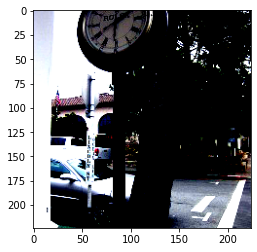

index : 1
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


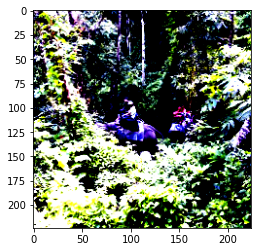

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 2
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.], dtype=torch.float64)


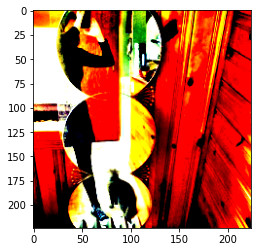

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 3
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float64)


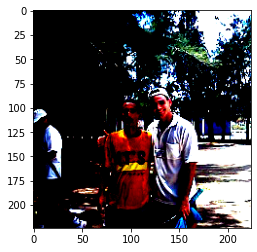

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 4
image label : tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float64)


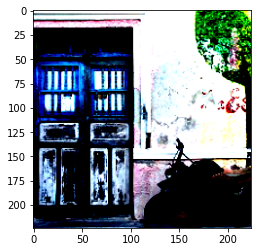

done!


In [ ]:
## Reconstruct some images -- note: images have been normalised 
for i in range(5):
    print('index : {}'.format(i))
    print('image label : {}'.format(labels[i]))
    # print(labels[i])
    npimg = images[i].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('done!')

### Functions and definitions necessary for evaluation

In [ ]:
def accuracy(predicted, original):  
    """
    Calculates the number of labels correctly predicted for each image
    """
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

In [ ]:
## Create list of class names for matching in the evaluation and prediction stage
class_names = np.array(list(range(1, 20)))

### Try to implement a simple NN for testing

In [ ]:
# Implement a simple CNN for testing 

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(3*224*224, 20)
    self.fc2 = nn.Linear(20, 19)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    return self.sigmoid(x)

### Simple NN Training with hypermarameters

In [ ]:
# https://pytorch.org/docs/stable/optim.html
model_simple = Net().to(dev)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_simple.parameters(), lr=0.01, momentum=0.9)
model_simple.train()

# Set desired no. epochs for training stage
no_epochs = 25

## Perform training stage 
for epoch in range(no_epochs): 
  print(f'epoch {epoch + 1}')

  start = time.time()
  ep_loss = 0.0
  ep_acc = 0.0
  
  ## Enumerate through data
  for i, (inputs,labels) in enumerate(train_loader, 0):
    # print(i)
    # Get the inputs
    inputs = inputs.view(-1, 3*224*224)
    inputs = inputs.to(dev)
    labels = labels.to(dev)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    outputs = model_simple(inputs)
    # print(outputs.size(), labels.size())
    # print(outputs)
    loss = criterion(outputs.float(), labels.float())
    ep_loss += loss
    ep_acc += accuracy(outputs.cpu(), labels.cpu())

    loss.backward()
    optimizer.step()
  
  print(f'Loss: {ep_loss/(i+1) :.3f}, Accuracy: {ep_acc/(i+1) :.3f}')
  print(f'time taken to run: {time.time() - start}')

epoch 1
Loss: 0.789, Accuracy: 10.530
time taken to run: 0.4391136169433594
epoch 2
Loss: 0.762, Accuracy: 12.416
time taken to run: 0.4299759864807129
epoch 3
Loss: 0.680, Accuracy: 13.805
time taken to run: 0.4127342700958252
epoch 4
Loss: 0.587, Accuracy: 15.116
time taken to run: 0.41301941871643066
epoch 5
Loss: 0.521, Accuracy: 16.398
time taken to run: 0.4182770252227783
epoch 6
Loss: 0.317, Accuracy: 16.952
time taken to run: 0.41789674758911133
epoch 7
Loss: 0.151, Accuracy: 17.798
time taken to run: 0.40752649307250977
epoch 8
Loss: 0.107, Accuracy: 18.219
time taken to run: 0.4360370635986328
epoch 9
Loss: 0.081, Accuracy: 18.496
time taken to run: 0.4379868507385254
epoch 10
Loss: 0.047, Accuracy: 18.683
time taken to run: 0.42838168144226074
epoch 11
Loss: 0.034, Accuracy: 18.725
time taken to run: 0.4237961769104004
epoch 12
Loss: 0.022, Accuracy: 18.846
time taken to run: 0.41553521156311035
epoch 13
Loss: 0.020, Accuracy: 18.858
time taken to run: 0.4205188751220703
epo

#### NN Evaluation

In [ ]:
## Set up the model for validation stage
model_simple.eval()

pred_results = np.array(range(1,20)).reshape(1,19)
target_results = np.array(range(1,20)).reshape(1,19)
print(target_results.shape, target_results)

# Enumerate through the validation dataset
for step, (inputs, label) in enumerate(validation_loader):
  epoch_loss = 0.0
  epoch_accuracy = 0.0
  inputs = inputs.view(-1, 3*224*224)

  # Load data to GPU (if available)
  inputs = torch.Tensor.cpu(inputs).to(dev)
  label = torch.Tensor.cpu(label).to(dev)

  # Make predictions
  y_pred = model_simple(inputs)
  preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
  preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()
  targets_np = torch.Tensor.cpu(label).detach().numpy()

  # Store predictions
  pred_results = np.concatenate((pred_results, preds_np), axis=0)
  target_results = np.concatenate((target_results, targets_np), axis=0)

  # Store results for each epoch
  acc = accuracy(preds_rounded.cpu(), label.cpu())
  epoch_loss += criterion(y_pred.float(), label.float())
  epoch_accuracy += acc

print(epoch_loss/(len(validation_loader)))
print(epoch_accuracy/(len(validation_loader)))
print(pred_results.shape, target_results.shape)

(1, 19) [[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
tensor(2.7336, device='cuda:0', grad_fn=<DivBackward0>)
10.65
(21, 19) (21, 19)


In [ ]:
classes = [str(i).zfill(2) for i in range(1,20)]
print(class_names, classes)
print(classification_report(target_results[1:], pred_results[1:], target_names=classes , zero_division=1))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
              precision    recall  f1-score   support

          01       0.60      0.46      0.52        13
          02       0.10      1.00      0.18         1
          03       0.00      0.00      0.00         2
          04       0.00      1.00      0.00         0
          05       0.11      1.00      0.20         1
          06       0.00      1.00      0.00         0
          07       0.00      1.00      0.00         0
          08       0.00      1.00      0.00         0
          09       0.20      1.00      0.33         2
          10       0.00      0.00      0.00         1
          11       0.00      1.00      0.00         0
          12       0.00      1.00      0.00         0
          13       0.00      1.00      0.00         0
          14       0.00      1.00      0.00         0
          15   

In [ ]:
## Make test predictions
model_simple.eval()
pred_results = np.array(range(1,20)).reshape(1,19)
images = []
predictions = []

for step, (inputs) in enumerate(test_loader):
  images.append(test_dataset.annotations.ImageID[step])
  inputs = inputs.view(-1, 3*224*224)
  inputs = torch.Tensor.cpu(inputs).to(dev)

  y_pred = model_simple(inputs)

  preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
  preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()
  # print(f'Predicted: {preds_np[0]}')
  # print(preds_np[0] == 1.0)
  preds_classes = class_names[preds_np[0] == 1.0]
  preds_string = [str(int) for int in preds_classes]
  
  predictions.append(' '.join(preds_string))
  pred_results = np.concatenate((pred_results, preds_np), axis=0)

prediction_upload = pd.DataFrame(zip(images, predictions), columns = ['ImageID', 'Labels'])
prediction_upload.to_csv(data_path + '/test_predictions.csv', index = False)
prediction_upload.head()

,ImageID,Labels
0,0.jpg,1 2 5 6 8 9 13 14 15 16 19
1,1.jpg,1 19
2,2.jpg,1
3,3.jpg,3 8 13
4,4.jpg,3 7 8


## Modelling stage:
### Implement AlexNet

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=19, stem_stride=4):
        # invoke super class initialisation method
        super(AlexNet, self).__init__()
        
        # define the CNN:
        # 1. define feature extraction layers
        self.features = nn.Sequential(
            # conv-relu-pooling
            nn.Conv2d(3, 64, kernel_size=11, stride=stem_stride, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-pooling
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-conv-relu-conv-relu-pooling
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 2. define average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # 3. define fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),                   # use dropout
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),                   # use dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Sigmoid(),
        )

    # define forward-propagation
    def forward(self, x):
        # feature extraction
        x = self.features(x)
        # adaptive pooling layer
        x = self.avgpool(x)
        # flatten feature map
        x = torch.flatten(x, 1)
        # classification
        x = self.classifier(x)
        return x

### Model Training with hypermarameters

In [ ]:
## Initialise and train an alexnet model
model_alexnet = AlexNet().to(dev)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_alexnet.parameters(), lr = 3e-4)

train_loss_tracker = []
train_accuracy_tracker = []

epochs = 25
for epoch in range(epochs):
  print(f'Epoch no. {epoch + 1}')

  start = time.time()
  ep_loss = 0.0
  ep_acc = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    inputs = inputs.to(dev)
    labels = labels.to(dev)

    optimizer.zero_grad()

    outputs = model_alexnet(inputs)
    loss = criterion(outputs.float(), labels.float())
    ep_loss += loss

    acc = accuracy(outputs.to('cpu'), labels.to('cpu'))
    ep_acc += acc
    loss.backward()
    optimizer.step()
  
  train_loss_tracker.append(ep_loss/(i+1))
  train_accuracy_tracker.append(ep_acc/(i+1))
  print(f'Loss: {ep_loss/(i+1) :.3f}, Accuracy: {ep_acc/(i+1) :.3f}')
  print(f'time taken to run: {time.time() - start}')

Epoch no. 1
Loss: 0.189, Accuracy: 17.960
time taken to run: 3714.977905035019
Epoch no. 2
Loss: 0.178, Accuracy: 17.968
time taken to run: 99.92603325843811
Epoch no. 3
Loss: 0.173, Accuracy: 17.972
time taken to run: 100.54945540428162
Epoch no. 4
Loss: 0.169, Accuracy: 17.978
time taken to run: 100.43494987487793
Epoch no. 5
Loss: 0.166, Accuracy: 17.991
time taken to run: 99.71627736091614
Epoch no. 6
Loss: 0.162, Accuracy: 17.997
time taken to run: 99.0249445438385
Epoch no. 7
Loss: 0.159, Accuracy: 18.007
time taken to run: 97.09922099113464
Epoch no. 8
Loss: 0.155, Accuracy: 18.019
time taken to run: 96.48111724853516
Epoch no. 9
Loss: 0.150, Accuracy: 18.036
time taken to run: 95.22714138031006
Epoch no. 10
Loss: 0.145, Accuracy: 18.059
time taken to run: 93.59898853302002
Epoch no. 11
Loss: 0.140, Accuracy: 18.075
time taken to run: 92.94723153114319
Epoch no. 12
Loss: 0.134, Accuracy: 18.102
time taken to run: 92.56913685798645
Epoch no. 13
Loss: 0.127, Accuracy: 18.133
time 

In [ ]:
model_alexnet = AlexNet()
model_alexnet.load_state_dict(torch.load(data_path+'/trained_alexnet.pth'))
model_alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.BCELoss()
# optimizer = optim.Adam(model_alexnet.parameters(), lr = 3e-4)
# model_alexnet.to(dev)
model_alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Model Validation on validation set data

In [ ]:
pred_results = np.array(range(1,20)).reshape(1,19)
target_results = np.array(range(1,20)).reshape(1,19)
# print(target_results.shape, target_results)

validation_loss = 0.0
validation_accuracy = 0.0

for step, (inputs, label) in enumerate(validation_loader):
  print(step)
  inputs = torch.Tensor.cpu(inputs)#.to(dev)
  label = torch.Tensor.cpu(label)#.to(dev)

  # Make predictions
  y_pred = model_alexnet(inputs)
  preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
  preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()
  targets_np = torch.Tensor.cpu(label).detach().numpy()

  # Store predictions
  pred_results = np.concatenate((pred_results, preds_np), axis=0)
  target_results = np.concatenate((target_results, targets_np), axis=0)

  acc = accuracy(y_pred.cpu(), label.cpu())
  validation_loss += criterion(y_pred.float(), label.float())
  validation_accuracy += acc

average_validation_loss = validation_loss/(len(validation_loader))
average_validation_accuracy = validation_accuracy/(len(validation_loader))

print(f'Average validation loss: {average_validation_loss}')
print(f'Average validation accuracy: {average_validation_accuracy}')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Model evaluation
- Classification Report
- Confusion Matrix for all classes

In [ ]:
classes = [str(i).zfill(2) for i in range(1,20)]
print(class_names, classes)
print(classification_report(target_results[1:], pred_results[1:], target_names=classes , zero_division=1))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
              precision    recall  f1-score   support

          01       0.95      0.97      0.96      4589
          02       0.93      0.83      0.88       253
          03       0.93      0.81      0.87       881
          04       0.93      0.84      0.88       254
          05       0.90      0.88      0.89       228
          06       0.93      0.84      0.89       270
          07       0.92      0.87      0.89       232
          08       0.90      0.83      0.86       458
          09       0.92      0.83      0.87       209
          10       0.92      0.85      0.88       300
          11       0.97      0.85      0.91       147
          12       1.00      1.00      1.00         0
          13       0.92      0.88      0.90       117
          14       0.91      0.86      0.89        50
          15   

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, coverage_error
coverage_error(target_results[1:], pred_results[1:])

In [ ]:
multilabel_confusion_matrix(target_results[1:], pred_results[1:])

array([[[1195,  215],
        [ 125, 4464]],

       [[5729,   17],
        [  42,  211]],

       [[5064,   54],
        [ 164,  717]],

       [[5730,   15],
        [  41,  213]],

       [[5748,   23],
        [  27,  201]],

       [[5712,   17],
        [  42,  228]],

       [[5749,   18],
        [  30,  202]],

       [[5501,   40],
        [  80,  378]],

       [[5775,   15],
        [  35,  174]],

       [[5676,   23],
        [  45,  255]],

       [[5848,    4],
        [  22,  125]],

       [[5999,    0],
        [   0,    0]],

       [[5873,    9],
        [  14,  103]],

       [[5945,    4],
        [   7,   43]],

       [[5553,   32],
        [  94,  320]],

       [[5775,   15],
        [  59,  150]],

       [[5692,   15],
        [  67,  225]],

       [[5640,   23],
        [  72,  264]],

       [[5769,   16],
        [  49,  165]]])

## Test Prediction
- Initialize test loader
- Run and save predictions

In [ ]:
## Make test predictions
model_alexnet.eval()
pred_results_test = np.array(range(1,20)).reshape(1,19)
images = []
predictions = []

for step, (inputs) in enumerate(test_loader):
    if step % 100 == 0:
      print(step)
    images.append(test_dataset.annotations.ImageID[step])
    inputs = torch.Tensor.cpu(inputs)#.to(dev)
    inputs = inputs.unsqueeze(0)

    y_pred = model_alexnet(inputs)

    preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
    preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()

    preds_classes = class_names[preds_np[0] == 1.0]
    preds_string = [str(int) for int in preds_classes]
    
    predictions.append(' '.join(preds_string))
    pred_results_test = np.concatenate((pred_results_test, preds_np), axis=0)

prediction_upload = pd.DataFrame(zip(images, predictions), columns = ['ImageID', 'Labels'])
prediction_upload.to_csv(data_path + '/alexnet_test_predictions.csv', index = False)
prediction_upload.head()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1
